In [5]:
%matplotlib inline

import copy
from tqdm import tqdm
from functools import partial
from multiprocessing import Pool, cpu_count
import numpy as np
import scipy.special as special
import scipy.integrate as integrate
import scipy.optimize as optimize
import scipy.interpolate as interpolate
import matplotlib.pyplot as plt

import wf_func as wff

In [6]:
panellen = 1000
Gain = 155
beta = 36.6
tau = 3.895
sigma = 1.32
# Sigma = 40
Sigma = 0
spe_pre = wff.read_model('spe-jinp.h5')

In [7]:
def wavespe(t, tau, sigma):
    return np.where(t > 0, np.exp((sigma**2-2*tau*(t-4*sigma))/(2*tau**2)) * (1+special.erf((-sigma+(t-4*sigma)*tau/sigma)/(np.sqrt(2)*tau))) / (2*tau), 0)

def glow(n, beta):
    return np.random.exponential(beta, size=n)

def noise(n, rms):
    return np.random.normal(0, rms, n)

def gain(n, Gain, Sigma):
    return np.random.normal(Gain, Sigma, n)

# def wavespe(t, tau1, tau2):
#     return (np.exp(-t/tau1) - np.exp(-t/tau2))/(tau1 - tau2)

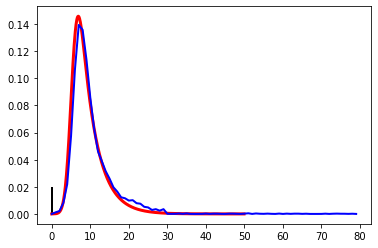

In [8]:
x = np.arange(0, 50, 0.1)
plt.plot(x, wavespe(x, tau, sigma), color='r', lw=3.)
plt.vlines(0, ymin=0, ymax=0.02, color='k')
plt.plot(np.arange(0, 80), spe_pre[0]['spe']/np.sum(spe_pre[0]['spe']), color='b')

In [9]:
# integrate.quad(wavespe, 0, 10000, args=(tau, sigma))

In [10]:
popt, pcov = optimize.curve_fit(wavespe, np.arange(0, 80), spe_pre[0]['spe']/np.sum(spe_pre[0]['spe']), p0=[3, 1])

In [11]:
waveform = np.vectorize(partial(wavespe, tau=tau, sigma=sigma))

In [12]:
panel = np.arange(panellen)
n = 10
rise = np.random.uniform(100, 400)
t = np.sort(glow(n, beta) + rise)
t = t[t < panellen]
charge = gain(n, Gain, Sigma)
wf = np.sum(np.multiply(waveform(panel.reshape(1, panellen) - t.reshape(n, 1)), charge[:, None]), axis=0)
wf = wf + noise(panellen, 1)

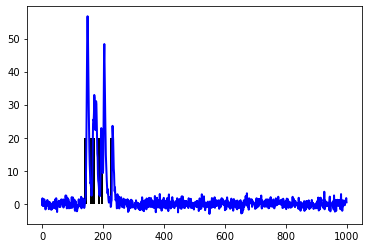

In [13]:
plt.close()
plt.plot(panel, wf, color='b')
plt.vlines(t, ymin=0, ymax=20, color='k')

In [14]:
# spe = np.mean([np.sum(np.multiply(waveform(panel.reshape(1, panellen)), gain(1, Gain, Sigma)[:, None]), axis=0) for i in range(100)], axis=0)
# plt.close()
# plt.plot(panel[0: 80], spe[0: 80], color='b')
# plt.plot(np.arange(0, 80), spe_pre[0]['spe'], color='r')
# plt.vlines(0, ymin=0, ymax=20, color='k')
# plt.plot(x, wavespe(x, tau, sigma) * Gain, color='m', lw=3.)

In [15]:
# spe_i = copy.deepcopy(spe_pre[0])
# spe_i['spe'] = wavespe(np.arange(0, 80), tau, sigma) * Gain
# pet, pwe = wff.xiaopeip(wf, spe_i)
# pet, pwe = wff.clip(pet, pwe, 0.1)
# pwe = pwe / pwe.sum() * np.abs(wf.sum())
# tth = {'RiseTime' : np.around(t).astype(np.int), 'EventID' : np.zeros(n).astype(np.int), 'ChannelID' : np.zeros(n).astype(np.int), 'Charge' : charge}
# wff.demo(pet, pwe, tth, spe_i, panellen, wf, 0, mode='Charge')

In [16]:
# thres = 5
# th = optimize.fsolve(lambda x : wavespe(x, tau, sigma) * Gain - thres, x0 = 3)[0]
# x0 = np.argwhere(wf > thres)[0] - th
# x0 = optimize.fsolve(lambda x : interpolate.interp1d(panel, wf)(x) - thres, x0 = np.argwhere(wf > thres)[0])[0] - th

In [17]:
np.random.seed(0)
N = 10000
spe_i = copy.deepcopy(spe_pre[0])
spe_i['spe'] = wavespe(np.arange(0, 80), tau, sigma) * Gain
panel = np.arange(panellen)
n = 10

deltat = np.zeros(N)
opdt = np.dtype([('Waveform', np.float, panellen), ('Rise', np.float), ('Time', np.float, n), ('Charge', np.float, n)])

def simulate_batch(a, b):
    S = np.zeros(b - a, dtype=opdt)
    for i in tqdm(range(b - a)):
        rise = np.random.uniform(100, 400)
        t = np.sort(glow(n, beta) + rise)
        charge = gain(n, Gain, Sigma)
        wf = np.sum(np.multiply(waveform(panel.reshape(1, panellen) - t.reshape(n, 1)), charge[:, None]), axis=0)
        S[i]['Waveform'] = wf + noise(panellen, 1.)
        S[i]['Rise'] = rise
        S[i]['Time'] = t
        S[i]['Charge'] = charge
    return S

def reconstruction_batch(a, b, S):
    deltat = np.zeros(b - a)
    for i in tqdm(range(a, b)):
        pet, pwe = wff.lucyddm(S[i]['Waveform'], spe_i)
        pet, pwe = wff.clip(pet, pwe, 0.1)
        pwe = pwe / pwe.sum() * np.abs(S[i]['Waveform'].sum())
        deltat[i - a] = pet.min() - S[i]['Time'][0]
    return deltat

Ncpu = 1
chunk = N // Ncpu + 1
slices = np.vstack((np.arange(0, N, chunk), np.append(np.arange(chunk, N, chunk), N))).T.astype(np.int).tolist()

with Pool(min(Ncpu, cpu_count())) as pool:
    S = np.hstack(pool.starmap(simulate_batch, slices))
    
with Pool(min(Ncpu, cpu_count())) as pool:
    deltat = np.concatenate(pool.starmap(partial(reconstruction_batch, S=S), slices))

100%|██████████| 100/100 [00:01<00:00, 70.09it/s]


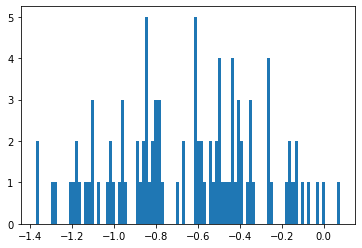

In [18]:
plt.close()
plt.hist(deltat, bins=100)
plt.savefig('likelihood.png')

In [19]:
i = np.argmax(deltat)
pet, pwe = wff.lucyddm(S[i]['Waveform'], spe_i)
pet, pwe = wff.clip(pet, pwe, 0.1)
pwe = pwe / pwe.sum() * np.abs(S[i]['Waveform'].sum())
tth = {'RiseTime' : np.around(S[i]['Time']).astype(np.int), 
       'EventID' : np.zeros(n).astype(np.int), 
       'ChannelID' : np.zeros(n).astype(np.int), 
       'Charge' : S[i]['Charge']}
wff.demo(pet, pwe, tth, spe_i, panellen, S[i]['Waveform'], 0, mode='Charge')

PEnum is 4
truth RiseTime = [245 246 249 251 257 277 284 299 300 312], Weight = [155. 155. 155. 155. 155. 155. 155. 155. 155. 155.]
truth Resi-norm = 34.611717802573466
RiseTime = [245 246 247 248 249 250 251 252 253 255 256 257 258 277 278 283 284 285
 298 299 300 311 312 313], Weight = [ 99.69858614 128.95053763  69.69503989  50.5222586   58.29818791
  81.2943225   71.86599775  39.79369466  18.02519173  18.81781347
  41.66411564  55.79772789  31.48443736  88.13431075  60.68624973
  39.91710371  69.78131912  38.96210247  34.23516151 175.93461878
  95.18535173  41.84309935  83.90652392  29.11847431]
wdist = 0.5949879582799137,cdiff = -26.38777344534219
Resi-norm = 33.03623135134399


In [28]:
tau = 36.6
sigma = 2.5
def convolve_exp_norm(x, tau, sigma):
    alpha = 1/tau
    co = alpha/2. * np.exp(alpha*alpha*sigma*sigma/2.)
    x_erf = (alpha*sigma*sigma - x)/(np.sqrt(2.)*sigma)
    y = co * np.exp(-alpha*x) * (1. - special.erf(x_erf))
    return y

In [29]:
integrate.quad(convolve_exp_norm, -10, 1000, args=(tau, sigma))

(0.999999519042436, 1.0339804117076579e-09)

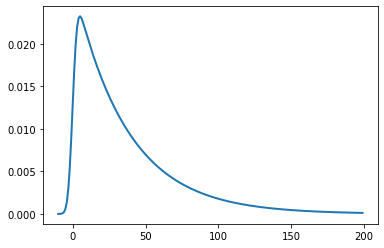

In [43]:
a = np.arange(-10, 200)
plt.close()
plt.plot(a, convolve_exp_norm(a, tau, sigma))